In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
%matplotlib inline

In [2]:
num_states = 16
num_rows = 4
num_actions = 4
max_timesteps = 7
goal_pos = [3,3]

## Deterministic Environment

In [3]:
class DeterministicGridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):
        self.observation_space = spaces.Discrete(num_states)
        self.action_space = spaces.Discrete(num_actions)
        self.max_timesteps = max_timesteps
        self.reward = np.array([[0,-1,-1,1],
                                [-1,-1,2,-1],
                                [4,-1,1,-1],
                                [-1,-1,-1,20]])
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0,0]
        self.goal_pos = goal_pos
        self.state = self.reward.copy()
        self.state[tuple(self.agent_pos)] = 10 # just to display
        observation = self.state.flatten()
        return observation
    
    def step(self, action):
        if action == 0:
            self.agent_pos[0] += 1
        if action == 1:
            self.agent_pos[0] -= 1
        if action == 2:
            self.agent_pos[1] += 1
        if action == 3:
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = self.reward.copy()
        
        self.state[tuple(self.agent_pos)] = 10 # just to display
        
        observation = self.state.flatten()
        
        reward = self.reward[tuple(self.agent_pos)]
        self.timestep += 1
        done = True if self.timestep >= self.max_timesteps else False
        if (self.agent_pos == self.goal_pos).all():
            done = True

        agent_state = self.agent_pos[0]*self.action_space.n+self.agent_pos[1]
        info = {"agent_state" : agent_state}
        return observation, reward, done, info
        
    def render(self):
        plt.imshow(self.state)

#### Random Agent

In [4]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        
    def step(self, observation):
        return np.random.choice(self.action_space.n)

#### Random agent behavior for Deterministic environment

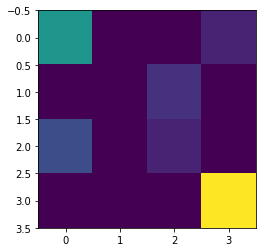

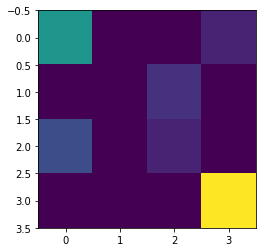

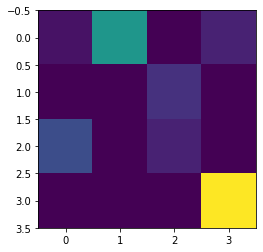

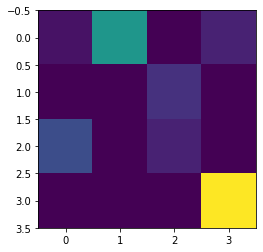

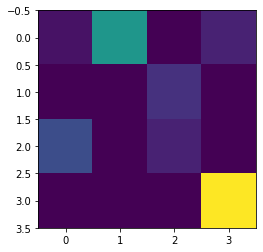

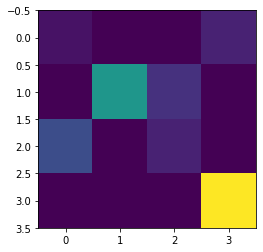

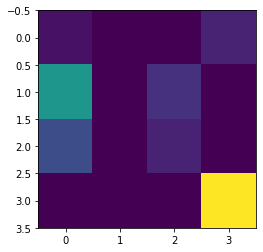

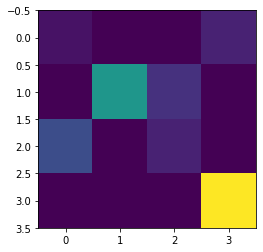

Total reward:  -6
Total number of steps:  7


In [5]:
# Display random agent behavior for deterministic environment
env = DeterministicGridEnvironment()
agent = RandomAgent(env)

obs = env.reset()
done = False
total_reward = 0
number_of_steps = 0

while not done:
    env.render()
    plt.show()
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    total_reward+=reward
    number_of_steps+=1

#Display end position
env.render()
plt.show()
print("Total reward: ", total_reward)
print("Total number of steps: ", number_of_steps)


## Stochastic Environment

In [6]:
class StochasticGridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):
        self.observation_space = spaces.Discrete(num_states)
        self.action_space = spaces.Discrete(num_actions)
        self.max_timesteps = max_timesteps
        self.reward = np.array([[0,-1,-1,1],
                                [-1,-1,2,-1],
                                [4,-1,1,-1],
                                [-1,-1,-1,20]])
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0,0]
        self.goal_pos = goal_pos        
        self.state = self.reward.copy()
        self.state[tuple(self.agent_pos)] = 10 # just to display
        observation = self.state.flatten()
        return observation
    
    def step(self, action):
        # Select specified action with higher probability. Change action with small probability for stochastic behaviour
        p=[0.94, 0.02, 0.02, 0.02]
        actions = np.random.choice(4, 1, p=p)
        action += actions[0]
        # Prevent overflow of action value
        if action > 3:
            action-=3
        if action == 0:
            self.agent_pos[0] += 1
        if action == 1:
            self.agent_pos[0] -= 1
        if action == 2:
            self.agent_pos[1] += 1
        if action == 3:
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = self.reward.copy()
        self.state[tuple(self.agent_pos)] = 10 # just to display
        observation = self.state.flatten()
        
        reward = self.reward[tuple(self.agent_pos)]
        self.timestep += 1
        done = True if self.timestep >= self.max_timesteps else False
        if (self.agent_pos == self.goal_pos).all():
            done = True

        agent_state = self.agent_pos[0]*self.action_space.n+self.agent_pos[1]
        info = {"agent_state" : agent_state}
        return observation, reward, done, info
        
    def render(self):
        plt.imshow(self.state)

#### Random agent behavior for Stochastic environment

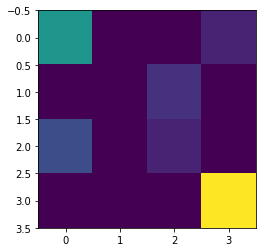

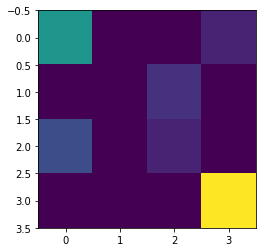

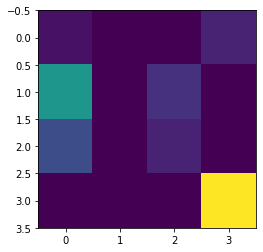

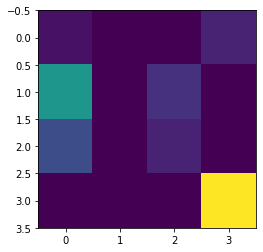

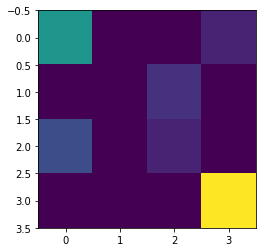

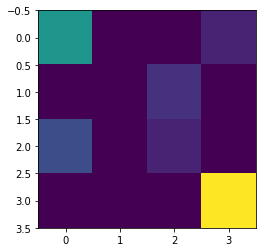

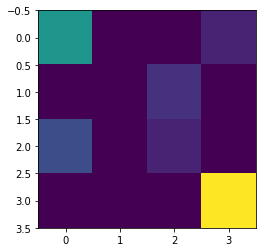

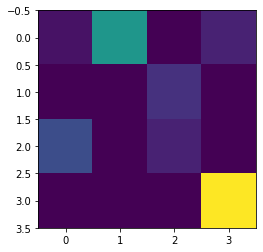

Total reward:  -3
Total number of steps:  7


In [7]:
# Display random agent behavior for stochastic environment
env = StochasticGridEnvironment()
agent = RandomAgent(env)

obs = env.reset()
done = False
total_reward = 0
number_of_steps = 0

while not done:
    env.render()
    plt.show()
    action = agent.step(obs)
    number_of_steps+=1
    obs, reward, done, info = env.step(action)
    total_reward+=reward

#Display end position
env.render()
plt.show()
print("Total reward: ", total_reward)
print("Total number of steps: ", number_of_steps)


## DynamicProgrammingAgent

In [8]:
class DynamicProgrammingAgent:
    
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        dimension_size = self.action_space.n
        state_size = self.observation_space.n
        self.reward = env.reward
        self.reward = self.reward.flatten()
        
        #Initialize V_0
        self.V_0 = np.zeros((state_size))
        self.V_0[state_size-1] = 100
        self.V_0[0] = -100
        
        #Initialize policy
        self.policy = {}
        random_direction = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        for i in range(state_size):
            self.policy[i] = random_direction.copy()
        
        #Calculate state_prime for all states
        self.state_prime = {}
        for i in range(state_size):
            temp = {}
            temp[0]=i+dimension_size if i+dimension_size<state_size else i
            temp[1]=i-dimension_size if i-dimension_size>-1 else i
            temp[2]=i+1 if (i+1)%dimension_size!=0 else i
            temp[3]=i-1 if (i+dimension_size)%dimension_size!=0 else i
            self.state_prime[i] = temp

    def probability_to_transition(self,s1,s2,action):
        if(self.state_prime[s1][action]==s2):
            return 1
        else:
            return 0    
    
    def policy_evaluation(self):
        delta = 10
        gamma = 0.5
        threshold = 0.5
        count = 0
        V = self.V_0
        dimension_size = self.action_space.n
        state_size = self.observation_space.n
        
        while delta > threshold:
            delta = 0
            count+=1
            V_next = []
            for S in range(state_size):
                if S==state_size-1 or S==0 : 
                    V_next.insert(S,V[S])
                    continue
                V_S = V[S]
                V_S_next = 0
                for action in range(dimension_size) : 
                    S_prime = self.state_prime[S][action]
                    if max(self.policy[S_prime].values()) < 1.0:
                        V_S_next += self.policy[S][action]*self.probability_to_transition(S,S_prime,action)*(self.reward[S_prime]+gamma*V[S_prime])
                V_S_next = round(V_S_next,2)
                if V_S_next == 0:
                    V_next.insert(S,V[S])
                else:
                    delta = max(delta,abs(V_S - V_S_next))
                    V_next.insert(S, V_S_next)
            if delta > threshold:
                V = V_next
        
        self.V_0 = V.copy()
        self.policy_improvement()
        
    def policy_improvement(self) :
        V = self.V_0.copy()
        state_size = self.observation_space.n
        eps = 0.0
        policy_stable = True
        
        for i in range(state_size):
            old_action = self.policy[i].copy()
            down = V[self.state_prime[i][0]] 
            up = V[self.state_prime[i][1]] 
            right = V[self.state_prime[i][2]]
            left = V[self.state_prime[i][3]] 
            maximum_V = max(down,up,right,left)

            set_down = False if abs(down-maximum_V) > eps else True
            set_up = False if abs(up-maximum_V) > eps else True
            set_right = False if abs(right-maximum_V) > eps else True
            set_left = False if abs(left-maximum_V) > eps else True
            ups = sum([set_down,set_up,set_right,set_left])
            new_probability = 1/ups

            self.policy[i][0] = new_probability if set_down == True else 0
            self.policy[i][1] = new_probability if set_up == True else 0
            self.policy[i][2] = new_probability if set_right == True else 0
            self.policy[i][3] = new_probability if set_left == True else 0
            
            new_action = self.policy[i]
            if(old_action != new_action):
                policy_stable = False;

        if policy_stable == False:
            self.policy_evaluation()
        
        
    def step(self, observation, agent_state):
        return max(self.policy[agent_state], key=self.policy[agent_state].get)



#### DP trained agent behavior for deterministic environment

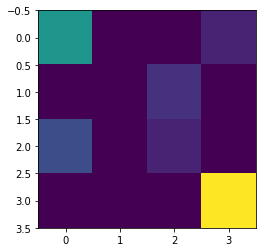

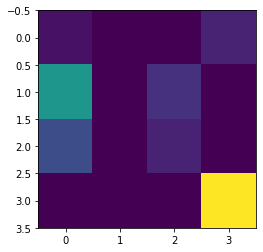

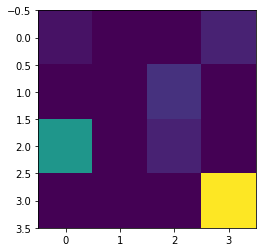

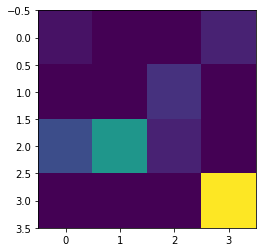

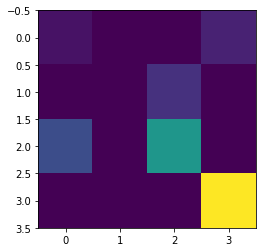

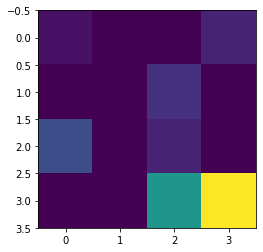

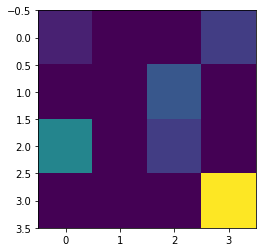

Total reward:  22
Total number of steps:  6


In [9]:
# Display DP trained agent behavior for deterministic environment
env = DeterministicGridEnvironment()
agent = DynamicProgrammingAgent(env)


obs = env.reset()
done = False
agent.policy_evaluation()
total_reward = 0
number_of_steps = 0
agent_state = 0

while not done:
    env.render()
    plt.show()
    action = agent.step(obs, agent_state)
    number_of_steps+=1
    obs, reward, done, info = env.step(action)
    total_reward+=reward
    agent_state = info["agent_state"]

#Display end position
env.render()
plt.show()
print("Total reward: ", total_reward)
print("Total number of steps: ", number_of_steps)

#### DP trained agent behavior for Stochastic environment

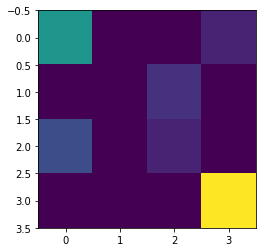

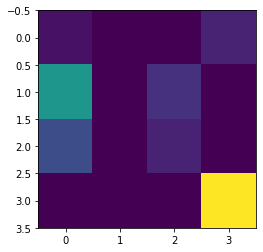

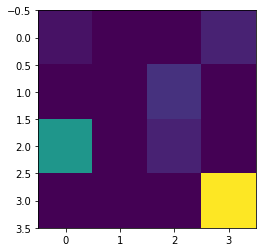

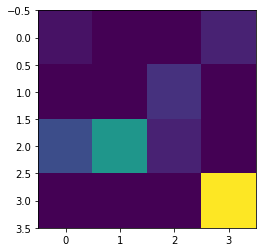

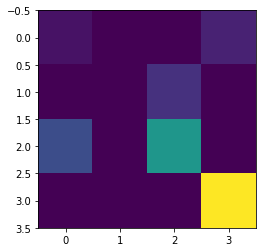

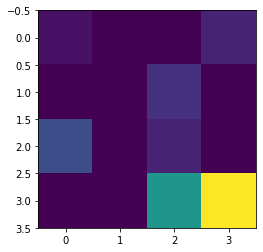

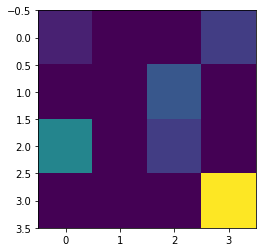

Total reward:  22
Total number of steps:  6


In [10]:
# DP trained agent behavior for Stochastic environment
env = StochasticGridEnvironment()
agent = DynamicProgrammingAgent(env)


obs = env.reset()
done = False
agent.policy_evaluation()

total_reward = 0
number_of_steps = 0
agent_state = 0

while not done:
    env.render()
    plt.show()
    action = agent.step(obs, agent_state)
    number_of_steps+=1
    obs, reward, done, info = env.step(action)
    total_reward+=reward
    agent_state = info["agent_state"]

#Display end position
env.render()
plt.show()
print("Total reward: ", total_reward)
print("Total number of steps: ", number_of_steps)